In [1]:
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.pipeline import Pipeline
import pickle
import scipy.sparse
import os
from eval_funcs import *
warnings.filterwarnings("ignore")

## Loading datasets from `analysis_no_features` notebook

In [2]:
# Load sparse matrices
tf_idf_vectors = scipy.sparse.load_npz('./datasets/train_sparse_matrix.npz')
X_test_tfidf = scipy.sparse.load_npz('./datasets/test_sparse_matrix.npz')

In [3]:
# Load tfidf feature names list
# if file exists we have already pickled a list
if os.path.isfile("tfidf_features.txt"):
    with open("tfidf_features.txt", 'rb') as f:
        tfidf_feature_names = pickle.load(f)

In [4]:
#Load X_train and X_test
X_train = pd.read_csv('./datasets/wikihow_X_train.csv') 
X_test = pd.read_csv('./datasets/wikihow_X_test.csv') 

In [5]:
#Load y_train and y_test 
y_train = pd.read_csv('./datasets/wikihow_y_train.csv', header = None) 
y_test = pd.read_csv('./datasets/wikihow_y_test.csv', header = None) 

## Reconstructing Dataframes for analysis 
Let's add some features to see if our model performs better. We start by adding the sentences length feture to see how it performs.

In [6]:
X_train_ft = X_train[['sentence','sentence_len']]

In [7]:
#Reshaping the sentence lengths array 
sent_lengths = np.array(X_train_ft['sentence_len'].values).reshape(-1, 1)

In [8]:
sent_lengths

array([[14],
       [ 9],
       [11],
       ...,
       [ 7],
       [ 9],
       [14]])

In [9]:
#Converting sentence lengths array to sparse matrix
sparse_sent_lengths = scipy.sparse.csr_matrix(sent_lengths)

In [10]:
sparse_sent_lengths

<70000x1 sparse matrix of type '<class 'numpy.int64'>'
	with 70000 stored elements in Compressed Sparse Row format>

In [11]:
#Concatenating the two sparse arrays  
X_train_feats = scipy.sparse.hstack([tf_idf_vectors,sparse_sent_lengths ])

In [12]:
#Check the shape of the arrays  
X_train_feats.shape

(70000, 94995)

In [13]:
#Same with test set 
X_test_ft = X_test[['sentence','sentence_len']]

In [14]:
#Reshaping the sentence lengths array 
sent_lengths_test = np.array(X_test_ft['sentence_len'].values).reshape(-1, 1)

In [15]:
#Converting sentence lengths array to sparse matrix
sparse_sent_lengths_test = scipy.sparse.csr_matrix(sent_lengths_test)

In [16]:
#Concatenating the two sparse arrays  
X_test_feats = scipy.sparse.hstack([X_test_tfidf,sparse_sent_lengths_test ])

In [17]:
X_test_feats.shape

(30000, 94995)

## Perform Cross-Validation with a Naive Bayes Classifier 

In [18]:
nb = MultinomialNB()
param_grid = {'alpha': (0.1, 1, 5, 10, 50)}

In [19]:
nb_CV = GridSearchCV(estimator=nb, param_grid=param_grid, cv=5, scoring = 'f1')

In [20]:
nb_CV.fit(X_train_feats, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': (0.1, 1, 5, 10, 50)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring='f1', verbose=0)

In [21]:
nb_CV.best_params_

{'alpha': 0.1}

## Classification using Naive Bayes with tf idf scores and sentence lengths

In [22]:
preds = nb_CV.predict(X_test_feats)

In [23]:
print(f'Confusion Matrix: \n {metrics.confusion_matrix(y_test, preds)}')

Confusion Matrix: 
 [[24809   258]
 [ 3114  1819]]


In [24]:
print(f'Classification Report: \n\n {metrics.classification_report(y_test, preds)}')

Classification Report: 

               precision    recall  f1-score   support

           0       0.89      0.99      0.94     25067
           1       0.88      0.37      0.52      4933

    accuracy                           0.89     30000
   macro avg       0.88      0.68      0.73     30000
weighted avg       0.89      0.89      0.87     30000



## Classification using Naive Bayes with BoW and sentence lengths

In [25]:
#Performing Cross Validation for the best combination of parameters
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=2)
X_train_dtm = vectorizer.fit_transform(X_train['sentence'])
X_train_dtm_dense = X_train_dtm.toarray() 
len(X_train_dtm_dense)

70000

### Add features to X_train_dtm and X_test_dtm 

In [26]:
X_train_bow_feats = scipy.sparse.hstack([X_train_dtm ,sparse_sent_lengths ])
X_train_bow_feats

<70000x99757 sparse matrix of type '<class 'numpy.int64'>'
	with 1718399 stored elements in COOrdinate format>

In [27]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vectorizer.transform(X_test['sentence'])
X_test_dtm

<30000x99756 sparse matrix of type '<class 'numpy.int64'>'
	with 675443 stored elements in Compressed Sparse Row format>

In [28]:
X_test_bow_feats =scipy.sparse.hstack([X_test_dtm ,sparse_sent_lengths_test ])
X_test_bow_feats

<30000x99757 sparse matrix of type '<class 'numpy.int64'>'
	with 705443 stored elements in COOrdinate format>

### Perform MultinomialNB Classification 

In [29]:
nb_bow = MultinomialNB(alpha=0.1)

In [30]:
nb_bow.fit(X_train_bow_feats, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [31]:
preds_bow= nb_bow.predict(X_test_bow_feats)

In [32]:
print(f'Confusion Matrix: \n {metrics.confusion_matrix(y_test, preds_bow)}')

Confusion Matrix: 
 [[23551  1516]
 [ 2022  2911]]


In [33]:
print(f'Classification Report: \n\n {metrics.classification_report(y_test, preds_bow)}')

Classification Report: 

               precision    recall  f1-score   support

           0       0.92      0.94      0.93     25067
           1       0.66      0.59      0.62      4933

    accuracy                           0.88     30000
   macro avg       0.79      0.76      0.78     30000
weighted avg       0.88      0.88      0.88     30000



**Precision** - For both classes we have pretty high precision although for class 1 it is lower than the precision for the same class with th multinomialNB classifier with no features (0.77)

**Recall (sensitivity)** - is the ratio of correctly predicted positive observations to the all observations in actual class, with adding the sentence length feature, we get a higher recall for class 1 (summary) as opposed to the same classifier without this feature (0.41).

**F1 score** - F1 is usually more useful than accuracy, especially since we have an uneven class distribution. In our case, F1 score is 0.88, but we notice the the F1 score for the summary class has improved (0.62) compared to the model without the `sentence_len` feature (0.53).

Overall the recall for the summary class here is significantly better probably because the MultinomialNB classifier works best with integers (suitable for classification with discrete features).

## Adding the `tfidf_score` to the MultinomialNB model

In [34]:
X_train_ft = X_train[['sentence_len', 'tfidf_score']]

In [35]:
sent_tfidf = np.array(X_train_ft['tfidf_score'].values).reshape(-1, 1)

In [36]:
#Converting sentence tfidf array to sparse matrix
sparse_sent_tfidf = scipy.sparse.csr_matrix(sent_tfidf)

In [37]:
X_train_bow_feats_1 = scipy.sparse.hstack([X_train_bow_feats ,sparse_sent_tfidf])
X_train_bow_feats_1

<70000x99758 sparse matrix of type '<class 'numpy.float64'>'
	with 1788390 stored elements in COOrdinate format>

In [38]:
#Same for test set
X_test_ft = X_test[['sentence','tfidf_score']]
sent_tfidf_test = np.array(X_test_ft['tfidf_score'].values).reshape(-1, 1)
#Converting sentence tfidf array to sparse matrix
sparse_sent_tfidf_test = scipy.sparse.csr_matrix(sent_tfidf_test)
#Concatenating the two sparse arrays  
X_test_bow_feats_1 = scipy.sparse.hstack([X_test_bow_feats,sparse_sent_tfidf_test])

In [39]:
X_test_bow_feats_1

<30000x99758 sparse matrix of type '<class 'numpy.float64'>'
	with 735440 stored elements in COOrdinate format>

In [40]:
nb_bow_1 = MultinomialNB(alpha=0.1)
nb_bow_1.fit(X_train_bow_feats_1, y_train)
preds_bow_1= nb_bow_1.predict(X_test_bow_feats_1)

In [41]:
print(f'Confusion Matrix: \n {metrics.confusion_matrix(y_test, preds_bow_1)}')

Confusion Matrix: 
 [[23508  1559]
 [ 1472  3461]]


In [42]:
print(f'Classification Report: \n\n {metrics.classification_report(y_test, preds_bow_1)}')

Classification Report: 

               precision    recall  f1-score   support

           0       0.94      0.94      0.94     25067
           1       0.69      0.70      0.70      4933

    accuracy                           0.90     30000
   macro avg       0.82      0.82      0.82     30000
weighted avg       0.90      0.90      0.90     30000



This model performs even better 

## Adding the `title_similarity` feature to the MultinomialNB model

In [43]:
X_train_ft = X_train[['sentence_len', 'title_similarity']]

In [44]:
X_train_ft[X_train_ft['title_similarity'] < 0].count()

sentence_len        4
title_similarity    4
dtype: int64

In [45]:
#We only have 3 negative values, let's try making them 0 and see if the model is better this way
X_train_ft[X_train_ft['title_similarity'] < 0] = 0

In [46]:
X_train_ft[X_train_ft['title_similarity'] < 0].count()

sentence_len        0
title_similarity    0
dtype: int64

In [47]:
sent_title_similarity = np.array(X_train_ft['title_similarity'].values).reshape(-1, 1)

In [48]:
#Converting sentence tfidf array to sparse matrix
sparse_sent_title_similarity = scipy.sparse.csr_matrix(sent_title_similarity)

In [49]:
X_train_bow_feats_2 = scipy.sparse.hstack([X_train_bow_feats_1 ,sparse_sent_title_similarity])
X_train_bow_feats_2

<70000x99759 sparse matrix of type '<class 'numpy.float64'>'
	with 1858386 stored elements in COOrdinate format>

In [50]:
#Same for test set
X_test_ft = X_test[['sentence','title_similarity']]
sent_title_similarity_test = np.array(X_test_ft['title_similarity'].values).reshape(-1, 1)
#Converting sentence tfidf array to sparse matrix
sparse_sent_title_similarity_test = scipy.sparse.csr_matrix(sent_title_similarity_test)
#Concatenating the two sparse arrays  
X_test_bow_feats_2 = scipy.sparse.hstack([X_test_bow_feats_1,sparse_sent_title_similarity_test])

In [51]:
X_test_bow_feats_2

<30000x99759 sparse matrix of type '<class 'numpy.float64'>'
	with 765438 stored elements in COOrdinate format>

In [52]:
nb_bow_2 = MultinomialNB(alpha=0.1)
nb_bow_2.fit(X_train_bow_feats_2, y_train)
preds_bow_2= nb_bow_2.predict(X_test_bow_feats_2)

In [53]:
print(f'Confusion Matrix: \n {metrics.confusion_matrix(y_test, preds_bow_2)}')

Confusion Matrix: 
 [[23491  1576]
 [ 1403  3530]]


In [54]:
print(f'Classification Report: \n\n {metrics.classification_report(y_test, preds_bow_2)}')

Classification Report: 

               precision    recall  f1-score   support

           0       0.94      0.94      0.94     25067
           1       0.69      0.72      0.70      4933

    accuracy                           0.90     30000
   macro avg       0.82      0.83      0.82     30000
weighted avg       0.90      0.90      0.90     30000



This model give slighlty better results.

In [55]:
from eval_funcs import *
#New text never before seen and make predictions on it 
text_1_df = pd.read_csv('./datasets/text_1.csv')
text_1_vectors = vectorizer.transform(text_1_df['sentence'])
text_1_df['title_similarity'] = text_1_df.apply(lambda x: get_similarity(x['sentence'], x['title']), axis=1)
text_1_feat = prediction_preprocessing(text_1_df)
text_1_full_feats = scipy.sparse.hstack([text_1_vectors,text_1_feat])
pred_text_1 = nb_bow_2.predict(text_1_full_feats)
results_text_1 = text_1_df[['sentence','is_summary']]
results_text_1['predictions'] = pred_text_1
print(recreate_summaries(results_text_1))

Real Summary: 

Stop what you re doing. Take a break. Focus on your senses. Take some deep breaths. Inhale slowly through your nose. Try to relax your muscles. Get some exercise. Recognize what stress looks like for you. Identify the cause of your stress. Acknowledge your role. Determine if you re stressing about something that is in the past. Determine whether you re stressed about the future. Practice relaxation. Inhale deeply through your nose. Think about something else. Choose your response. Make a plan. Be realistic. Take one step at a time. Stop procrastinating. Practice mindfulness. Try a self compassion break. Use the RAIN reminder. Repeat positive statements. Release stress productively. Cry if you want to. Listen to some soothing music. Take a hot shower or bath 

Predicted Summary: 

Take a break. Focus on your senses. I feel nauseated. Try to relax your muscles. Loosen tight clothing if possible. Give yourself seconds to notice how these areas feel. Give yourself a second 

In [56]:
#Calculate recall for text 1
len(results_text_1[(results_text_1['is_summary'] == results_text_1['predictions'])&(results_text_1['predictions']==1)])
len(results_text_1[results_text_1['is_summary']==1])

recall_text_1 = len(results_text_1[(results_text_1['is_summary'] == results_text_1['predictions'])&(results_text_1['predictions']==1)])/len(results_text_1[results_text_1['is_summary']==1])
recall_text_1


0.7142857142857143

In [57]:
#New text never before seen and make predictions on it 
text_2_df = pd.read_csv('./datasets/text_2.csv')
text_2_vectors = vectorizer.transform(text_2_df['sentence'])
text_2_df['title_similarity'] = text_2_df.apply(lambda x: get_similarity(x['sentence'], x['title']), axis=1)
text_2_feat = prediction_preprocessing(text_2_df)
text_2_full_feats = scipy.sparse.hstack([text_2_vectors,text_2_feat])
pred_text_2 = nb_bow_2.predict(text_2_full_feats)
results_text_2 = text_2_df[['sentence','is_summary']]
results_text_2['predictions'] = pred_text_2
print(recreate_summaries(results_text_2))

Real Summary: 

Know that everyone has their own unique experience with grief. Acknowledge that there are many kinds of loss. Recognize that stages of mourning do not really exist. Distinguish between grief and mourning. Learn about the necessary tasks of mourning. Acknowledge that you and others may not experience grief the same way. Recognize physical symptoms of grief. Recognize emotional symptoms of grief. Recognize signs of grief in children. Recognize signs of complicated grief. Acknowledge your emotions. Express your feelings through a tangible medium. Acknowledge that your grief is yours. Maintain your physical health. Avoid using alcohol, drugs, or food to deal with your grief. Do things that you enjoy. Prepare for things that may trigger your grief. Pamper yourself. Look to family members and friends for support. Join a support group. Speak with a grief counselor or therapist. Find comfort in the things you believe in. Get involved with your community. Allow yourself to remem

In [58]:
#Calculate recall for text 2
len(results_text_2[(results_text_2['is_summary'] == results_text_2['predictions'])&(results_text_2['predictions']==1)])
len(results_text_2[results_text_2['is_summary']==1])

recall_text_2 = len(results_text_2[(results_text_2['is_summary'] == results_text_2['predictions'])&(results_text_2['predictions']==1)])/len(results_text_2[results_text_2['is_summary']==1])
recall_text_2

0.5161290322580645

In [59]:
#New text never before seen and make predictions on it 
text_3_df = pd.read_csv('./datasets/text_3.csv')
text_3_vectors = vectorizer.transform(text_3_df['sentence'])
text_3_df['title_similarity'] = text_3_df.apply(lambda x: get_similarity(x['sentence'], x['title']), axis=1)
text_3_feat = prediction_preprocessing(text_3_df)
text_3_full_feats = scipy.sparse.hstack([text_3_vectors,text_3_feat])
pred_text_3 = nb_bow_2.predict(text_3_full_feats)
results_text_3 = text_3_df[['sentence','is_summary']]
results_text_3['predictions'] = pred_text_3
print(recreate_summaries(results_text_3))

Real Summary: 

Think about the time commitment of ferret proofing your home. See if you have enough time to play with a ferret. Remember that ferrets require training. Keep cleaning time in mind. Remember a ferret s lifespan. Consider other factors. Avoid a ferret if you have young children. Think about how busy your home is. Consider your other pets. Decide whether you can tolerate the smell. Make sure you can legally keep a ferret in your home. Learn about adoption and purchase fees. Make sure you can afford vaccinations. Consider the cost of sterilization. Weigh in other general costs of care 

Predicted Summary: 

Think about the time commitment of ferret proofing your home. Be honest with yourself about whether you have time for ferret proofing. Ferrets do sleep a lot. Consider other factors. Think about how busy your home is. First, ferrets are underfoot a lot. Consider your other pets. Also, think about legally housing a ferret. Check with your landlord before adopting a ferret

In [60]:
#Calculate recall for text 3
len(results_text_3[(results_text_3['is_summary'] == results_text_3['predictions'])&(results_text_3['predictions']==1)])
len(results_text_3[results_text_3['is_summary']==1])

recall_text_3 = len(results_text_3[(results_text_3['is_summary'] == results_text_3['predictions'])&(results_text_3['predictions']==1)])/len(results_text_3[results_text_3['is_summary']==1])
recall_text_3

0.4

In [61]:
print(calculate_compression(results_text_1))
print(calculate_compression(results_text_2))
print(calculate_compression(results_text_3))

Real Compression: 0.0830860534124629 

Predicted Compression: 0.10979228486646884 

Recall: 0.7142857142857143
None
Real Compression: 0.11742424242424243 

Predicted Compression: 0.09090909090909091 

Recall: 0.5161290322580645
None
Real Compression: 0.14150943396226415 

Predicted Compression: 0.10377358490566038 

Recall: 0.4
None


## Calculate the recalls accross articles and evaluate the recall distribution 

In [62]:
recalls = calculate_recall_distribution(X_test, preds_bow_2, y_test)

In [63]:
ids = [item[0] for item in recalls ]
recalls = [item[1] for item in recalls ]

In [64]:
recalls_df = pd.DataFrame(ids , columns=['id'])

In [65]:
recalls_df['recalls']= recalls

In [66]:
recalls_df.head(20)

,id,recalls
0,4354,1.0
1,4355,1.0
2,4356,NaN
3,4357,1.0
4,4358,1.0
5,5009,1.0
6,5010,1.0
7,5011,0.0
8,5094,1.0
9,6245,0.0


In [67]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))

plt.hist(recalls_df['recalls'])

(array([ 301.,    3.,   26.,   53.,   18.,  287.,  123.,   74.,   59.,
        1104.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

In [68]:
recalls_df[recalls_df['recalls'].isnull() == True].count()

id         471
recalls      0
dtype: int64

In [69]:
recalls_df[recalls_df['recalls'].isnull() == False].count()

id         2048
recalls    2048
dtype: int64

## Using LDA for classification

In [70]:
X_train_dtm.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [71]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10,random_state=42)
#fit model to the training data
#X_train_dtm.toarray().shape
lda_dtf = lda.fit_transform(X_train_dtm)

## Unsupervised: Using KMeans on these modelled topics 

In [72]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(lda_dtf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=2, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [73]:
unsupervised_preds = model.predict(lda_dtf)

In [74]:
unsupervised_preds.reshape(-1,1)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [75]:
print(f'Confusion Matrix: \n {metrics.confusion_matrix(y_train, unsupervised_preds.reshape(-1,1))}')

Confusion Matrix: 
 [[48884  9466]
 [ 8891  2759]]


In [76]:
print(f'Classification Report: \n\n {metrics.classification_report(y_train, unsupervised_preds.reshape(-1,1))}')

Classification Report: 

               precision    recall  f1-score   support

           0       0.85      0.84      0.84     58350
           1       0.23      0.24      0.23     11650

    accuracy                           0.74     70000
   macro avg       0.54      0.54      0.54     70000
weighted avg       0.74      0.74      0.74     70000



Precision here is very low

## Using all features + LDA in a supervised way (Multinomial Naive Bayes Classifier)

In [77]:
#Create X_train by concatenating the full features X_train with lda 
X_train_feats_lda = scipy.sparse.hstack([X_train_bow_feats_2,lda_dtf])


In [78]:
#Create X_test 
lda_dtf_test = lda.transform(X_test_dtm)
#Create X_train by concatenating the full features X_train with lda 
X_test_feats_lda = scipy.sparse.hstack([X_test_bow_feats_2,lda_dtf_test])

## Cross validate RF with and without LDA and predict

In [79]:
#With all the features
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=42,n_jobs=-1, class_weight='balanced')
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth':[4,5,6,7,8]
}
# Find the best parameters for both the feature extraction and the classifier
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring = 'f1')
CV_rfc.fit(X_train_bow_feats_2, y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                              

In [80]:
CV_rfc.best_params_

{'max_depth': 8, 'n_estimators': 500}

In [81]:
y_pred_class_rfc = CV_rfc.predict(X_test_bow_feats_2)
y_pred_class_rfc

array([1, 0, 0, ..., 1, 1, 0])

In [82]:
print(f'Confusion Matrix: \n {metrics.confusion_matrix(y_test, y_pred_class_rfc)}')

Confusion Matrix: 
 [[20499  4568]
 [  554  4379]]


In [83]:
print(f'Classification Report: \n\n {metrics.classification_report(y_test, y_pred_class_rfc)}')

Classification Report: 

               precision    recall  f1-score   support

           0       0.97      0.82      0.89     25067
           1       0.49      0.89      0.63      4933

    accuracy                           0.83     30000
   macro avg       0.73      0.85      0.76     30000
weighted avg       0.89      0.83      0.85     30000



(array([ 124.,    2.,    5.,   17.,    6.,  100.,   72.,   37.,   53.,
        1632.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

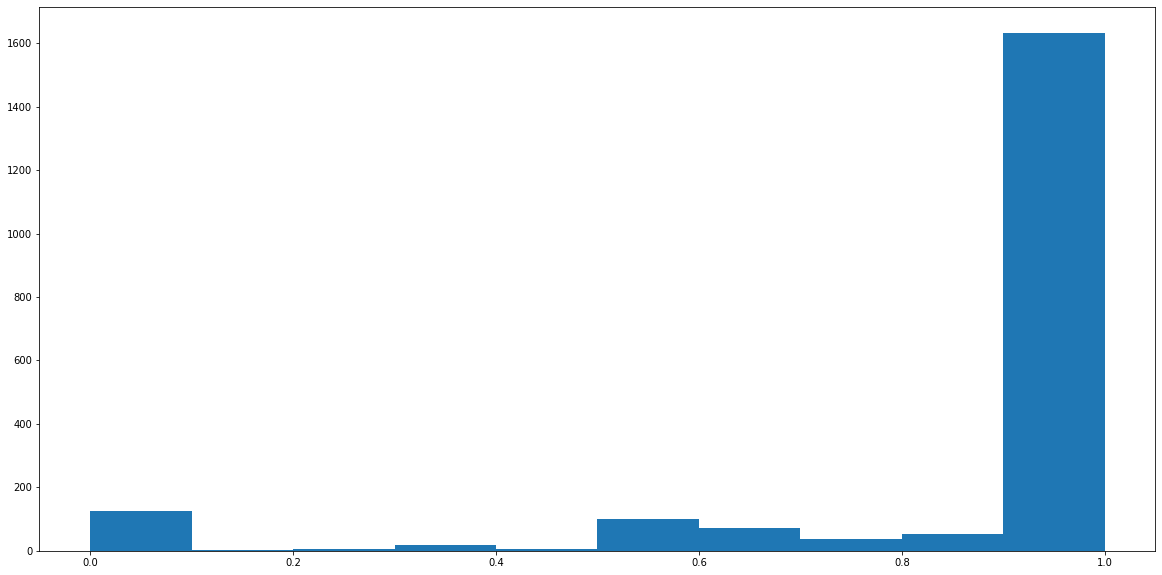

In [84]:
recalls = calculate_recall_distribution(X_test, y_pred_class_rfc, y_test)
ids = [item[0] for item in recalls ]
recalls = [item[1] for item in recalls ]
recalls_df_rf = pd.DataFrame(ids , columns=['id'])
recalls_df_rf['recalls']= recalls

plt.figure(figsize=(20,10))

plt.hist(recalls_df_rf['recalls'])

In [85]:
#New text never before seen and make predictions on it 
text_1_df = pd.read_csv('./datasets/text_1.csv')
text_1_vectors = vectorizer.transform(text_1_df['sentence'])
text_1_df['title_similarity'] = text_1_df.apply(lambda x: get_similarity(x['sentence'], x['title']), axis=1)
text_1_feat = prediction_preprocessing(text_1_df)
text_1_full_feats = scipy.sparse.hstack([text_1_vectors,text_1_feat])
pred_text_1_rf = CV_rfc.predict(text_1_full_feats)
results_text_1_rf = text_1_df[['sentence','is_summary']]
results_text_1_rf['predictions'] = pred_text_1_rf
print(recreate_summaries(results_text_1_rf))

Real Summary: 

Stop what you re doing. Take a break. Focus on your senses. Take some deep breaths. Inhale slowly through your nose. Try to relax your muscles. Get some exercise. Recognize what stress looks like for you. Identify the cause of your stress. Acknowledge your role. Determine if you re stressing about something that is in the past. Determine whether you re stressed about the future. Practice relaxation. Inhale deeply through your nose. Think about something else. Choose your response. Make a plan. Be realistic. Take one step at a time. Stop procrastinating. Practice mindfulness. Try a self compassion break. Use the RAIN reminder. Repeat positive statements. Release stress productively. Cry if you want to. Listen to some soothing music. Take a hot shower or bath 

Predicted Summary: 

Stop what you re doing. Take a break. I can do this. Focus on your senses. My heart is beating very fast. My palms feel sweaty. I feel nauseated. Take some deep breaths. Aim to breathe from you

In [86]:
#New text never before seen and make predictions on it 
text_2_df = pd.read_csv('./datasets/text_2.csv')
text_2_vectors = vectorizer.transform(text_2_df['sentence'])
text_2_df['title_similarity'] = text_2_df.apply(lambda x: get_similarity(x['sentence'], x['title']), axis=1)
text_2_feat = prediction_preprocessing(text_2_df)
text_2_full_feats = scipy.sparse.hstack([text_2_vectors,text_2_feat])
pred_text_2_rf = CV_rfc.predict(text_2_full_feats)
results_text_2_rf = text_2_df[['sentence','is_summary']]
results_text_2_rf['predictions'] = pred_text_2_rf
print(recreate_summaries(results_text_2_rf))

Real Summary: 

Know that everyone has their own unique experience with grief. Acknowledge that there are many kinds of loss. Recognize that stages of mourning do not really exist. Distinguish between grief and mourning. Learn about the necessary tasks of mourning. Acknowledge that you and others may not experience grief the same way. Recognize physical symptoms of grief. Recognize emotional symptoms of grief. Recognize signs of grief in children. Recognize signs of complicated grief. Acknowledge your emotions. Express your feelings through a tangible medium. Acknowledge that your grief is yours. Maintain your physical health. Avoid using alcohol, drugs, or food to deal with your grief. Do things that you enjoy. Prepare for things that may trigger your grief. Pamper yourself. Look to family members and friends for support. Join a support group. Speak with a grief counselor or therapist. Find comfort in the things you believe in. Get involved with your community. Allow yourself to remem

In [87]:
#New text never before seen and make predictions on it 
text_3_df = pd.read_csv('./datasets/text_3.csv')
text_3_vectors = vectorizer.transform(text_3_df['sentence'])
text_3_df['title_similarity'] = text_3_df.apply(lambda x: get_similarity(x['sentence'], x['title']), axis=1)
text_3_feat = prediction_preprocessing(text_3_df)
text_3_full_feats = scipy.sparse.hstack([text_3_vectors,text_3_feat])
pred_text_3_rf = CV_rfc.predict(text_3_full_feats)
results_text_3_rf = text_3_df[['sentence','is_summary']]
results_text_3_rf['predictions'] = pred_text_3_rf
print(recreate_summaries(results_text_3_rf))

Real Summary: 

Think about the time commitment of ferret proofing your home. See if you have enough time to play with a ferret. Remember that ferrets require training. Keep cleaning time in mind. Remember a ferret s lifespan. Consider other factors. Avoid a ferret if you have young children. Think about how busy your home is. Consider your other pets. Decide whether you can tolerate the smell. Make sure you can legally keep a ferret in your home. Learn about adoption and purchase fees. Make sure you can afford vaccinations. Consider the cost of sterilization. Weigh in other general costs of care 

Predicted Summary: 

Think about the time commitment of ferret proofing your home. Ferrets will chew such objects. Ferrets are social animals. Ferrets do sleep a lot. Remember that ferrets require training. Also, ferrets must be taught proper behavior. Ferrets are intelligent and highly trainable. However, like any animal, training takes time and persistence. Keep cleaning time in mind. Reme

In [88]:
print(calculate_compression(results_text_1_rf))
print(calculate_compression(results_text_2_rf))
print(calculate_compression(results_text_3_rf))

Real Compression: 0.0830860534124629 

Predicted Compression: 0.32344213649851633 

Recall: 0.9642857142857143
None
Real Compression: 0.11742424242424243 

Predicted Compression: 0.25757575757575757 

Recall: 0.9354838709677419
None
Real Compression: 0.14150943396226415 

Predicted Compression: 0.29245283018867924 

Recall: 0.8
None


In [89]:
rfc_lda = RandomForestClassifier(random_state=42,n_jobs=-1, class_weight='balanced')
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth':[4,5,6,7,8]
}
# Find the best parameters for both the feature extraction and the classifier
CV_rfc_lda = GridSearchCV(estimator=rfc_lda, param_grid=param_grid, cv=5, scoring = 'f1')
CV_rfc_lda.fit(X_train_feats_lda, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                              

In [90]:
CV_rfc_lda.best_params_

{'max_depth': 6, 'n_estimators': 100}

In [91]:
y_pred_class_rf = CV_rfc_lda.predict(X_test_feats_lda)
y_pred_class_rf

array([1, 0, 0, ..., 1, 1, 0])

In [92]:
print(f'Confusion Matrix: \n {metrics.confusion_matrix(y_test, y_pred_class_rf)}')

Confusion Matrix: 
 [[20248  4819]
 [  543  4390]]


In [93]:
print(f'Classification Report: \n\n {metrics.classification_report(y_test, y_pred_class_rf)}')

Classification Report: 

               precision    recall  f1-score   support

           0       0.97      0.81      0.88     25067
           1       0.48      0.89      0.62      4933

    accuracy                           0.82     30000
   macro avg       0.73      0.85      0.75     30000
weighted avg       0.89      0.82      0.84     30000



(array([1.220e+02, 1.000e+00, 3.000e+00, 2.000e+01, 8.000e+00, 9.000e+01,
        7.200e+01, 3.600e+01, 4.200e+01, 1.654e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

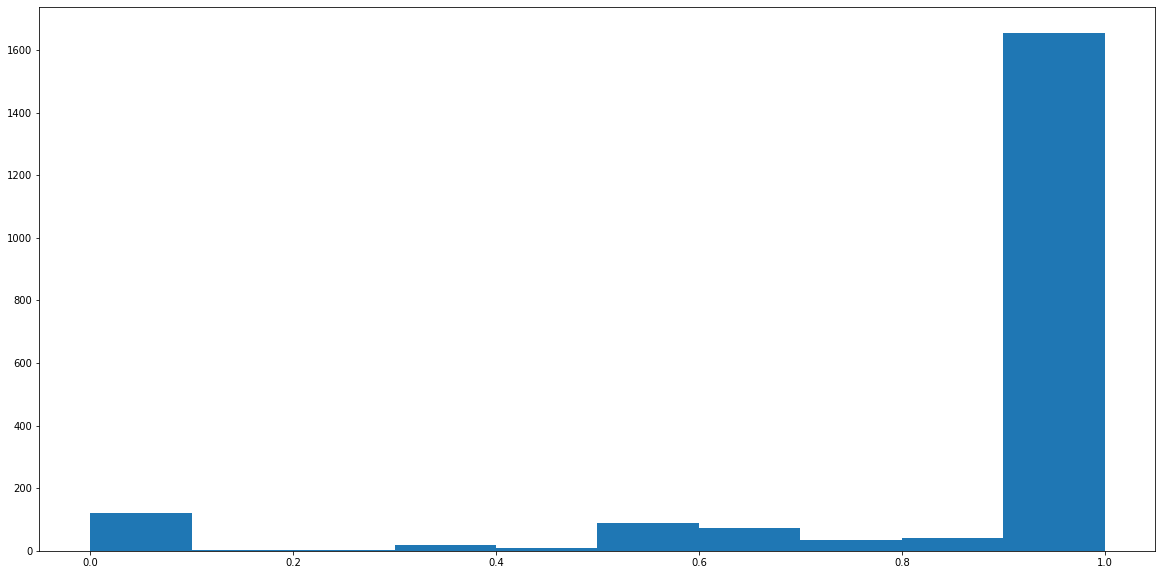

In [94]:
recalls = calculate_recall_distribution(X_test, y_pred_class_rf, y_test)
ids = [item[0] for item in recalls ]
recalls = [item[1] for item in recalls ]
recalls_df_rf_lda = pd.DataFrame(ids , columns=['id'])
recalls_df_rf_lda['recalls']= recalls

plt.figure(figsize=(20,10))

plt.hist(recalls_df_rf_lda['recalls'])

In [95]:
#New text never before seen and make predictions on it 
text_1_df = pd.read_csv('./datasets/text_1.csv')
text_1_vectors = vectorizer.transform(text_1_df['sentence'])
text_1_df['title_similarity'] = text_1_df.apply(lambda x: get_similarity(x['sentence'], x['title']), axis=1)
text_1_feat = prediction_preprocessing(text_1_df)
text_1_full_feats = scipy.sparse.hstack([text_1_vectors,text_1_feat])
lda_dtf_text_1 = lda.transform(text_1_vectors)
text_1_feats_lda = scipy.sparse.hstack([text_1_full_feats,lda_dtf_text_1])
pred_text_1_rf = CV_rfc_lda.predict(text_1_feats_lda)
results_text_1_rf = text_1_df[['sentence','is_summary']]
results_text_1_rf['predictions'] = pred_text_1_rf
print(recreate_summaries(results_text_1_rf))

Real Summary: 

Stop what you re doing. Take a break. Focus on your senses. Take some deep breaths. Inhale slowly through your nose. Try to relax your muscles. Get some exercise. Recognize what stress looks like for you. Identify the cause of your stress. Acknowledge your role. Determine if you re stressing about something that is in the past. Determine whether you re stressed about the future. Practice relaxation. Inhale deeply through your nose. Think about something else. Choose your response. Make a plan. Be realistic. Take one step at a time. Stop procrastinating. Practice mindfulness. Try a self compassion break. Use the RAIN reminder. Repeat positive statements. Release stress productively. Cry if you want to. Listen to some soothing music. Take a hot shower or bath 

Predicted Summary: 

Stop what you re doing. Take a break. I can do this. Focus on your senses. My heart is beating very fast. My palms feel sweaty. I feel nauseated. Take some deep breaths. Aim to breathe from you

In [96]:
#New text never before seen and make predictions on it 
text_2_df = pd.read_csv('./datasets/text_2.csv')
text_2_vectors = vectorizer.transform(text_2_df['sentence'])
text_2_df['title_similarity'] = text_2_df.apply(lambda x: get_similarity(x['sentence'], x['title']), axis=1)
text_2_feat = prediction_preprocessing(text_2_df)
text_2_full_feats = scipy.sparse.hstack([text_2_vectors,text_2_feat])
lda_dtf_text_2 = lda.transform(text_2_vectors)
text_2_feats_lda = scipy.sparse.hstack([text_2_full_feats,lda_dtf_text_2])
pred_text_2_rf = CV_rfc_lda.predict(text_2_feats_lda)
results_text_2_rf = text_2_df[['sentence','is_summary']]
results_text_2_rf['predictions'] = pred_text_2_rf
print(recreate_summaries(results_text_2_rf))

Real Summary: 

Know that everyone has their own unique experience with grief. Acknowledge that there are many kinds of loss. Recognize that stages of mourning do not really exist. Distinguish between grief and mourning. Learn about the necessary tasks of mourning. Acknowledge that you and others may not experience grief the same way. Recognize physical symptoms of grief. Recognize emotional symptoms of grief. Recognize signs of grief in children. Recognize signs of complicated grief. Acknowledge your emotions. Express your feelings through a tangible medium. Acknowledge that your grief is yours. Maintain your physical health. Avoid using alcohol, drugs, or food to deal with your grief. Do things that you enjoy. Prepare for things that may trigger your grief. Pamper yourself. Look to family members and friends for support. Join a support group. Speak with a grief counselor or therapist. Find comfort in the things you believe in. Get involved with your community. Allow yourself to remem

In [97]:
#text_2_vectors
text_2_feat

<264x3 sparse matrix of type '<class 'numpy.float64'>'
	with 792 stored elements in COOrdinate format>

In [98]:
#New text never before seen and make predictions on it 
text_3_df = pd.read_csv('./datasets/text_3.csv')
text_3_vectors = vectorizer.transform(text_3_df['sentence'])
text_3_df['title_similarity'] = text_3_df.apply(lambda x: get_similarity(x['sentence'], x['title']), axis=1)
text_3_feat = prediction_preprocessing(text_3_df)
text_3_full_feats = scipy.sparse.hstack([text_3_vectors,text_3_feat])
lda_dtf_text_3 = lda.transform(text_3_vectors)
text_3_feats_lda = scipy.sparse.hstack([text_3_full_feats,lda_dtf_text_3])
pred_text_3_rf = CV_rfc_lda.predict(text_3_feats_lda)
results_text_3_rf = text_3_df[['sentence','is_summary']]
results_text_3_rf['predictions'] = pred_text_3_rf
print(recreate_summaries(results_text_3_rf))

Real Summary: 

Think about the time commitment of ferret proofing your home. See if you have enough time to play with a ferret. Remember that ferrets require training. Keep cleaning time in mind. Remember a ferret s lifespan. Consider other factors. Avoid a ferret if you have young children. Think about how busy your home is. Consider your other pets. Decide whether you can tolerate the smell. Make sure you can legally keep a ferret in your home. Learn about adoption and purchase fees. Make sure you can afford vaccinations. Consider the cost of sterilization. Weigh in other general costs of care 

Predicted Summary: 

Think about the time commitment of ferret proofing your home. Ferrets will chew such objects. Ferrets are social animals. Ferrets do sleep a lot. Remember that ferrets require training. Also, ferrets must be taught proper behavior. Ferrets are intelligent and highly trainable. However, like any animal, training takes time and persistence. Keep cleaning time in mind. You 

In [99]:
print(calculate_compression(results_text_1_rf))
print(calculate_compression(results_text_2_rf))
print(calculate_compression(results_text_3_rf))

Real Compression: 0.0830860534124629 

Predicted Compression: 0.3857566765578635 

Recall: 0.9642857142857143
None
Real Compression: 0.11742424242424243 

Predicted Compression: 0.25 

Recall: 0.8709677419354839
None
Real Compression: 0.14150943396226415 

Predicted Compression: 0.36792452830188677 

Recall: 0.8666666666666667
None


## Cross validate MultinomialNB and predict

In [100]:
nb_lda = MultinomialNB()
param_grid = {'alpha': (0.1, 1, 5, 10, 50)}
nb_CV_lda = GridSearchCV(estimator=nb_lda, param_grid=param_grid, cv=5, scoring = 'f1')
nb_CV_lda.fit(X_train_feats_lda, y_train)
nb_CV_lda.best_params_

{'alpha': 0.1}

In [101]:
y_pred_class_nb = nb_CV_lda.predict(X_test_feats_lda)
y_pred_class_nb

array([0, 0, 0, ..., 1, 0, 0])

In [102]:
print(f'Confusion Matrix: \n {metrics.confusion_matrix(y_test, y_pred_class_nb)}')

Confusion Matrix: 
 [[23432  1635]
 [ 1296  3637]]


In [103]:
print(f'Classification Report: \n\n {metrics.classification_report(y_test, y_pred_class_nb)}')

Classification Report: 

               precision    recall  f1-score   support

           0       0.95      0.93      0.94     25067
           1       0.69      0.74      0.71      4933

    accuracy                           0.90     30000
   macro avg       0.82      0.84      0.83     30000
weighted avg       0.91      0.90      0.90     30000



(array([ 275.,    3.,   17.,   48.,   20.,  270.,  118.,   80.,   58.,
        1159.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

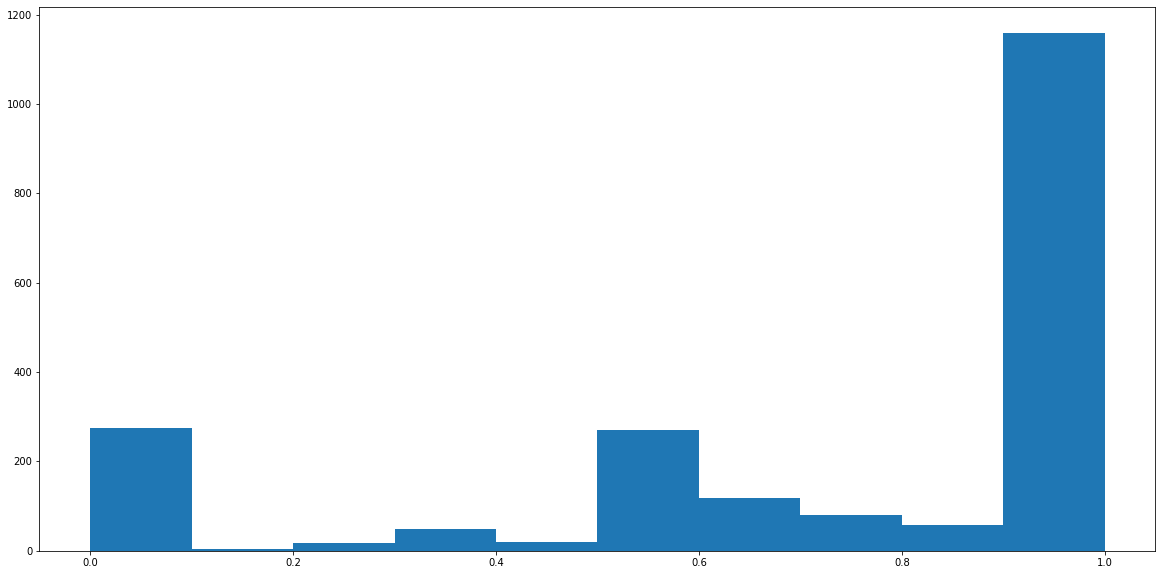

In [104]:
recalls = calculate_recall_distribution(X_test, y_pred_class_nb, y_test)
ids = [item[0] for item in recalls ]
recalls = [item[1] for item in recalls ]
recalls_df_nb_lda = pd.DataFrame(ids , columns=['id'])
recalls_df_nb_lda['recalls']= recalls

plt.figure(figsize=(20,10))

plt.hist(recalls_df_nb_lda['recalls'])

In [105]:
#New text never before seen and make predictions on it 
text_1_df = pd.read_csv('./datasets/text_1.csv')
text_1_vectors = vectorizer.transform(text_1_df['sentence'])
text_1_df['title_similarity'] = text_1_df.apply(lambda x: get_similarity(x['sentence'], x['title']), axis=1)
text_1_feat = prediction_preprocessing(text_1_df)
text_1_full_feats = scipy.sparse.hstack([text_1_vectors,text_1_feat])
lda_dtf_text_1 = lda.transform(text_1_vectors)
text_1_feats_lda = scipy.sparse.hstack([text_1_full_feats,lda_dtf_text_1])
pred_text_1_nb = nb_CV_lda.predict(text_1_feats_lda)
results_text_1_nb = text_1_df[['sentence','is_summary']]
results_text_1_nb['predictions'] = pred_text_1_nb
print(recreate_summaries(results_text_1_nb))

Real Summary: 

Stop what you re doing. Take a break. Focus on your senses. Take some deep breaths. Inhale slowly through your nose. Try to relax your muscles. Get some exercise. Recognize what stress looks like for you. Identify the cause of your stress. Acknowledge your role. Determine if you re stressing about something that is in the past. Determine whether you re stressed about the future. Practice relaxation. Inhale deeply through your nose. Think about something else. Choose your response. Make a plan. Be realistic. Take one step at a time. Stop procrastinating. Practice mindfulness. Try a self compassion break. Use the RAIN reminder. Repeat positive statements. Release stress productively. Cry if you want to. Listen to some soothing music. Take a hot shower or bath 

Predicted Summary: 

Take a break. Focus on your senses. I feel nauseated. Try to relax your muscles. Loosen tight clothing if possible. Give yourself seconds to notice how these areas feel. Give yourself a second 

In [106]:
text_2_df = pd.read_csv('./datasets/text_2.csv')
text_2_vectors = vectorizer.transform(text_2_df['sentence'])
text_2_df['title_similarity'] = text_2_df.apply(lambda x: get_similarity(x['sentence'], x['title']), axis=1)
text_2_feat = prediction_preprocessing(text_2_df)
text_2_full_feats = scipy.sparse.hstack([text_2_vectors,text_2_feat])
lda_dtf_text_2 = lda.transform(text_2_vectors)
text_2_feats_lda = scipy.sparse.hstack([text_2_full_feats,lda_dtf_text_2])
pred_text_2_nb = nb_CV_lda.predict(text_2_feats_lda)
results_text_2_nb = text_2_df[['sentence','is_summary']]
results_text_2_nb['predictions'] = pred_text_2_nb
print(recreate_summaries(results_text_2_nb))

Real Summary: 

Know that everyone has their own unique experience with grief. Acknowledge that there are many kinds of loss. Recognize that stages of mourning do not really exist. Distinguish between grief and mourning. Learn about the necessary tasks of mourning. Acknowledge that you and others may not experience grief the same way. Recognize physical symptoms of grief. Recognize emotional symptoms of grief. Recognize signs of grief in children. Recognize signs of complicated grief. Acknowledge your emotions. Express your feelings through a tangible medium. Acknowledge that your grief is yours. Maintain your physical health. Avoid using alcohol, drugs, or food to deal with your grief. Do things that you enjoy. Prepare for things that may trigger your grief. Pamper yourself. Look to family members and friends for support. Join a support group. Speak with a grief counselor or therapist. Find comfort in the things you believe in. Get involved with your community. Allow yourself to remem

In [107]:
text_3_df = pd.read_csv('./datasets/text_3.csv')
text_3_vectors = vectorizer.transform(text_3_df['sentence'])
text_3_df['title_similarity'] = text_3_df.apply(lambda x: get_similarity(x['sentence'], x['title']), axis=1)
text_3_feat = prediction_preprocessing(text_3_df)
text_3_full_feats = scipy.sparse.hstack([text_3_vectors,text_3_feat])
lda_dtf_text_3 = lda.transform(text_3_vectors)
text_3_feats_lda = scipy.sparse.hstack([text_3_full_feats,lda_dtf_text_3])
pred_text_3_nb = nb_CV_lda.predict(text_3_feats_lda)
results_text_3_nb = text_3_df[['sentence','is_summary']]
results_text_3_nb['predictions'] = pred_text_3_nb
print(recreate_summaries(results_text_3_nb))

Real Summary: 

Think about the time commitment of ferret proofing your home. See if you have enough time to play with a ferret. Remember that ferrets require training. Keep cleaning time in mind. Remember a ferret s lifespan. Consider other factors. Avoid a ferret if you have young children. Think about how busy your home is. Consider your other pets. Decide whether you can tolerate the smell. Make sure you can legally keep a ferret in your home. Learn about adoption and purchase fees. Make sure you can afford vaccinations. Consider the cost of sterilization. Weigh in other general costs of care 

Predicted Summary: 

Think about the time commitment of ferret proofing your home. Ferrets will chew such objects. Ferrets do sleep a lot. Remember a ferret s lifespan. Think about the stability of your living situation. Consider other factors. Think about how busy your home is. First, ferrets are underfoot a lot. Consider your other pets. Also, think about legally housing a ferret. Check wi

In [108]:
print(calculate_compression(results_text_1_nb))
print(calculate_compression(results_text_2_nb))
print(calculate_compression(results_text_3_nb))

Real Compression: 0.0830860534124629 

Predicted Compression: 0.11275964391691394 

Recall: 0.7142857142857143
None
Real Compression: 0.11742424242424243 

Predicted Compression: 0.0946969696969697 

Recall: 0.5161290322580645
None
Real Compression: 0.14150943396226415 

Predicted Compression: 0.12264150943396226 

Recall: 0.4666666666666667
None


In [109]:
results_text_1_nb['sentence'].count()

337